# Vehicle Detection and Tracking Project
Preform a Histogram of Oriented Gradient (HOG) feature extraction on labled training set of images and train a classifier (SVM or Decision Trees) Apply a color transform and append binned color features to the HOG feature vector. Experiment training your classifier on HOG / color features only, and then on the combination of the two Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing. Using a Decision Tree classifier, explore the feature importance and consider pruning or adding new features Implement a sliding-window technique and use your trained classifier to search for vehicles in images Estimate a bounding box for the vehicles detected. Run your pipeline on a video stream and implement tracking to follow detected vehicles Estimate distance and trajectory of detected vehicles.


Import Tools an libaries

In [40]:
import cv2
import glob
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC # Classifier
from sklearn.model_selection import train_test_split # data split
%matplotlib inline

Count Cars and Not Cars - from lesson 

In [41]:
images_car = glob.glob('vehicles/**/*.png')
images_noncar = glob.glob('non-vehicles/**/*.png')
print("Car amount = ", len(images_car), " and Noncar amount = ", len(images_noncar))

Car amount =  8792  and Noncar amount =  10175


Pull random images of cars from files

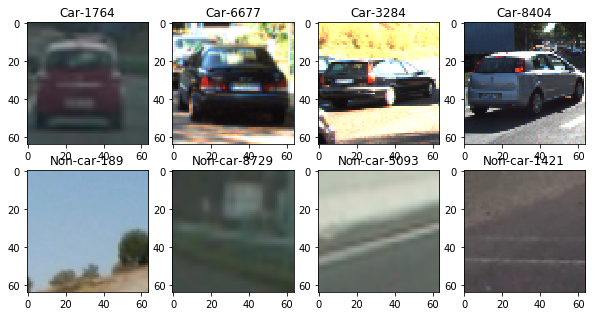

In [42]:
def random_cars():
    plt.figure(figsize=(10, 5))

    for i in range(4):
        random_car = np.random.randint(0, len(images_car)) # Choose a car image using the range function
        random_noncar = np.random.randint(0, len(images_noncar)) # Same for not car images

        car_image = mpimg.imread(images_car[random_car]) # Read a car image file
        notcar_image = mpimg.imread(images_noncar[random_noncar]) # Read a non-car image file
        
        # Plot images to screen

        plt.subplot(2, 4, i + 1)
        plt.imshow(car_image)
        plt.title('Car-' + str(random_car))
        plt.subplot(2, 4, i + 1 + 4)
        plt.imshow(notcar_image)
        plt.title('Non-car-' + str(random_noncar))


random_cars()

Create histogram - modified from the lesson and Q & A

In [43]:
def color_hist(img, nbins=32): # bins between 0 to 256
    chan1_hist = np.histogram(img[:, :, 0], bins=nbins)
    chan2_hist = np.histogram(img[:, :, 1], bins=nbins)
    chan3_hist = np.histogram(img[:, :, 2], bins=nbins)
    hist_features = np.concatenate((chan1_hist[0], chan2_hist[0], 
                                    chan3_hist[0]))
    return hist_features

Define the function get_hog_features  - from the lesson

In [44]:
def get_hog_feats(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                            pixels_per_cell=(pix_per_cell, pix_per_cell),
                            cells_per_block=(cell_per_block, cell_per_block),
                            transform_sqrt=False,
                            visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                             pixels_per_cell=(pix_per_cell, pix_per_cell),
                             cells_per_block=(cell_per_block, cell_per_block),
                             transform_sqrt=False,
                             visualise=vis, feature_vector=feature_vec)
        return features

Change color space and hog channel to find best reponse 

In [45]:
color_space = 'YUV'
hog_channel = 'ALL'
orient = 11
cell_per_block = 2
pix_per_cell = 16

Display Hog images - from the lesson 

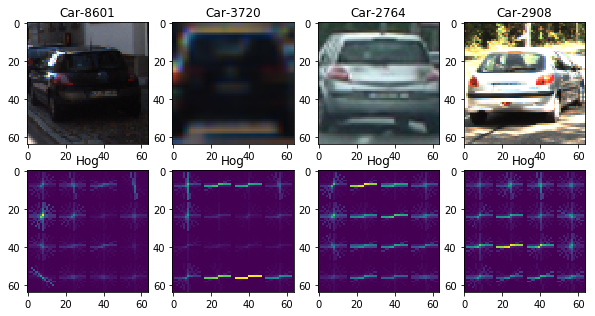

In [46]:
def show_hogs():
    plt.figure(figsize=(10, 5))

    for i in range(4):
        random_car = np.random.randint(0, len(images_car))
        random_noncar = np.random.randint(0, len(images_noncar))

        car_image = mpimg.imread(images_car[random_car])
        notcar_image = mpimg.imread(images_noncar[random_noncar])

        plt.subplot(2, 4, i + 1)
        plt.imshow(car_image)
        plt.title('Car-' + str(random_car))
        
        plt.subplot(2, 4, i + 1 + 4)
        feats, img_hog = get_hog_feats(car_image[:, :, 0],
                         orient, pix_per_cell, cell_per_block,
                         vis=True, feature_vec=True)
        plt.imshow(img_hog)
        plt.title('Hog')


show_hogs()

based on lesson in class

In [47]:
def extract_features(imgs, cspace='RGB', orient=9,
                    pix_per_cell=8, cell_per_block=2, hog_channel=0):
    feats = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                image_feat = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                image_feat = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                image_feat = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                image_feat = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                image_feat = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            image_feat = np.copy(image)

        if hog_channel == 'ALL':
            hog_feats = []
            for channel in range(image_feat.shape[2]):
                hog_feats.append(get_hog_feats(image_feat[:, :, channel],
                                    orient, pix_per_cell, cell_per_block,
                                    feature_vec=True))
            hog_feats = np.ravel(hog_feats)
        else:
            hog_feats = get_hog_feats(image_feat[:, :, hog_channel], orient,
                                    pix_per_cell, cell_per_block, feature_vec=True)
        feats.append(hog_feats)
    return feats

These parameters can be changed based on color_space and hog_channel

In [48]:
# Parameters of feature extraction
color_space = 'YUV'
hog_channel = 'ALL'
orient = 11
cell_per_block = 2
pix_per_cell = 16

extract hog features

In [49]:
features_car = extract_features(images_car, cspace=color_space, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
features_noncar = extract_features(images_noncar, cspace=color_space, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
print('HOG features extracted.')

HOG features extracted.


Display information for Hog Features needed for troubleshootng

In [50]:
X = np.vstack((features_car, features_noncar)).astype(np.float64)
y = np.hstack((np.ones(len(features_car)), np.zeros(len(features_noncar))))
# Split data into random training and test sets
rand_state = np.random.randint(0, 99)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rand_state)
print('Hog properties:')
print('orient = ', orient)
print('pix_per_cell = ', pix_per_cell)
print('cell_per_block = ', cell_per_block)
print('Lenght of feature vector:', len(X_train[0]))

Hog properties:
orient =  11
pix_per_cell =  16
cell_per_block =  2
Lenght of feature vector: 1188


Select and train a classifier 

In [51]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('SVC accuracy = ', round(svc.score(X_test, y_test), 4))
n_predict = 10
print('Predictions: ', svc.predict(X_test[0:n_predict]))
print('Real data:   ', y_test[0:n_predict])

SVC accuracy =  0.9805
Predictions:  [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
Real data:    [ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]


Display sample image

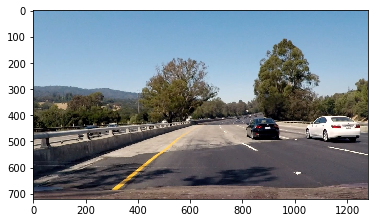

In [52]:
img_test = mpimg.imread('./test_images/test4.jpg')
img = img_test
plt.imshow(img_test)

Crop image to show only region we want to scan

In [53]:
ytop = 400
ybottom = 656
img_cropped = img[ytop:ybottom, :, :]

print('Original Shape =', img.shape)
print('Cropped Shape =', img_cropped.shape)

Original Shape = (720, 1280, 3)
Cropped Shape = (256, 1280, 3)


Display example image with area removed since you would not be looking for cars in the sky. 

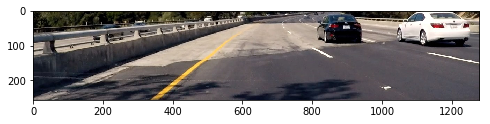

In [54]:
plt.figure(figsize=(8, 8))
plt.imshow(img_cropped)

Search for cars in the image, when found put a rectangle around it.

In [55]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    nxblocks = (ch1.shape[1] // pix_per_cell)+1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    
    hog1 = get_hog_feats(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_feats(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_feats(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

Parameters to use for search

In [56]:
ytop = 400
ybottom = 656
scale = 1.5
color_space = 'YUV'
hog_channel = 'ALL'
cell_per_block = 2
orient = 11
pix_per_cell = 16

Display count of rectangles found in the image.

In [57]:
rectangles = find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None, orient, pix_per_cell, 
                       cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

5 rectangles found in image


Function to draw boxes - from the lesson

In [58]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    random_color = False
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
            random_color = True
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [59]:
rects_img_test = draw_boxes(img_test, rectangles)

Display copy of sample image

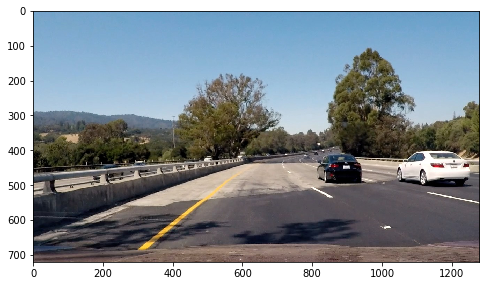

In [60]:
plt.figure(figsize=(8, 8))
plt.imshow(rects_img_test)

In [61]:
img_test = mpimg.imread('./test_images/test6.jpg')
rectangles = []
color_space = 'YUV'
hog_channel = 'ALL'
cell_per_block = 2
orient = 11
pix_per_cell = 16

Define each search window - from discussion, calculations and sugestions in the formum

In [62]:
ytop = 400
ybottom = 464
scale = 1.0
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

ytop = 416
ybottom = 480
scale = 1.0
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

ytop = 400
ybottom = 496
scale = 1.5
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

ytop = 432
ybottom = 528
scale = 1.5
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

ytop = 400
ybottom = 528
scale = 2.0
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

ytop = 432
ybottom = 560
scale = 2.0
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

ytop = 400
ybottom = 596
scale = 3.5
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

ytop = 464
ybottom = 660
scale = 3.5
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

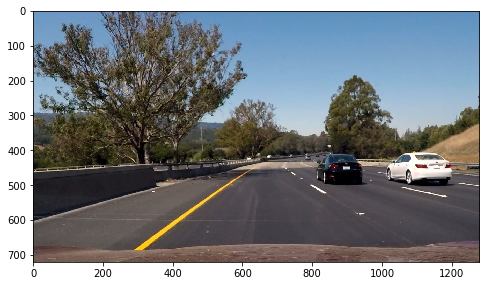

In [63]:
rectangles = [item for sublist in rectangles for item in sublist]
rects_img_test = draw_boxes(img_test, rectangles, thick=2)
plt.figure(figsize=(8, 8))
plt.imshow(rects_img_test)

Create heat map function

In [64]:
def heat_maper(heatmap, bounding_box_list):
    for box in bounding_box_list:
        # ((x1, y1) to (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

Heatmap parameters 

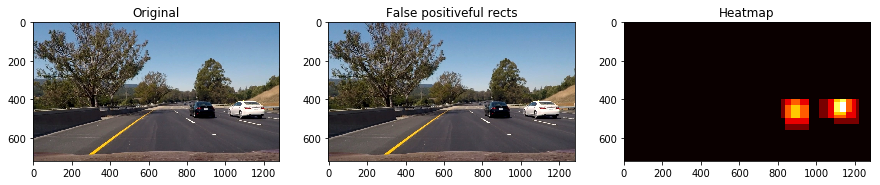

In [65]:
img_heatmap = np.zeros_like(img_test[:, :, 0])
img_heatmap = heat_maper(img_heatmap, rectangles)
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title('Original')
plt.imshow(img_test)
plt.subplot(132)
plt.title('False positiveful rects')
plt.imshow(rects_img_test)
plt.subplot(133)
plt.title('Heatmap')
plt.imshow(img_heatmap, cmap='hot')

Limit threshold on heatmap

In [66]:
def heatmap_tresholder(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

Show example of heatmap with threshold on image input

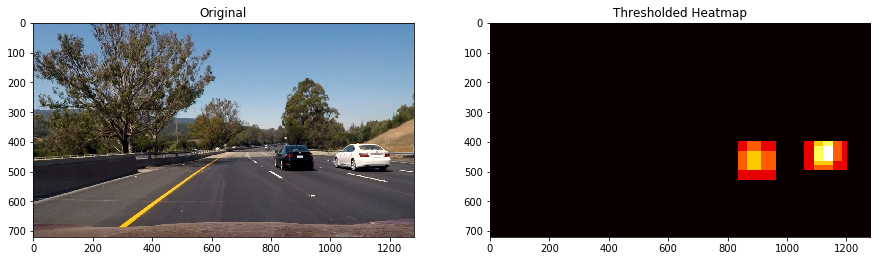

In [67]:
img_heatmap_threshold = heatmap_tresholder(img_heatmap, 1)
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('Original')
plt.imshow(img_test)
plt.subplot(122)
plt.title('Thresholded Heatmap')
plt.imshow(img_heatmap_threshold, cmap='hot')

Using heat map identiy cars found

2 cars found


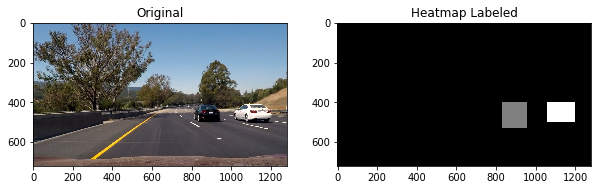

In [68]:
labels = label(img_heatmap)
plt.figure(figsize=(10, 10))
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Original')
plt.imshow(img_test)
plt.subplot(122)
plt.title('Heatmap Labeled')
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

function to draw boxes

In [69]:
def draw_bboxes_labeled(img, labels):
    rects = []
    for car_current in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_current).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bound_box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bound_box)
        cv2.rectangle(img, bound_box[0], bound_box[1], (0, 0, 255), 6)
    return img, rects

use the drawing boxes function from above to draw cars found on image

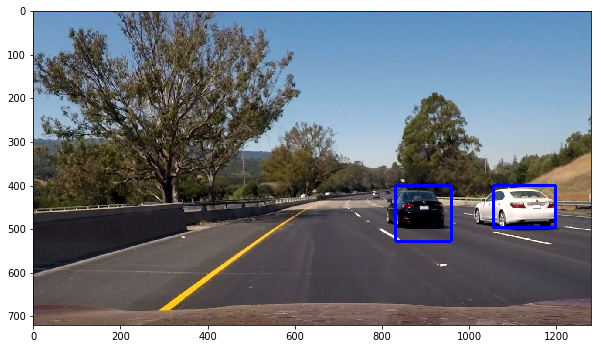

In [70]:
draw_img, rect = draw_bboxes_labeled(np.copy(img_test), labels)
plt.figure(figsize=(10, 10))
plt.imshow(draw_img)

create function to scan image using sliding windows to find a cars on the road, Note colorspace is choosen for best results

In [71]:
def process_frame_final(img):
    rectangles = []

    colorspace = 'YUV'
    hog_channel = 'ALL'
    cell_per_block = 2
    orient = 11
    pix_per_cell = 16

    ytop = 400
    ybottom = 464
    scale = 1.0
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 416
    ybottom = 480
    scale = 1.0
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 400
    ybottom = 496
    scale = 1.5
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 432
    ybottom = 528
    scale = 1.5
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 400
    ybottom = 528
    scale = 2.0
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 432
    ybottom = 560
    scale = 2.0
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 400
    ybottom = 596
    scale = 3.5
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 464
    ybottom = 660
    scale = 3.5
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist]

    if len(rectangles) > 0:
        a_vehicle.add_rects(rectangles)

    heatmap_img = np.zeros_like(img[:, :, 0])
    for rect_set in a_vehicle.old_rects:
        heatmap_img = heat_maper(heatmap_img, rect_set)
    heatmap_img = heatmap_tresholder(heatmap_img, 1 + len(a_vehicle.old_rects) // 2)

    labels = label(heatmap_img)
    draw_img, rect = draw_bboxes_labeled(np.copy(img), labels)
    return draw_img

create class to create or destory rectangle based on results

In [72]:
class Vehicler():
    def __init__(self):
        # history of rectangles previous n frames
        self.old_rects = []

    def add_rects(self, new_rects):
        self.old_rects.append(new_rects)
        if len(self.old_rects) > 15:
            # throw out oldest rectangle set(s)
            self.old_rects = self.old_rects[len(self.old_rects) - 15:]

Test on a sample video file of cars to see if they can be identified correctly, create mp4 file

In [ ]:
a_vehicle = Vehicler()
test_out_file_name = 'test_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame_final)
clip_test_out.write_videofile(test_out_file_name, audio=False)

Display video in jupyter notebook

In [39]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('test_out.mp4'))

Test on larger file size of video to see if correctly identifys the cars on the road. 

In [ ]:
a_vehicle = Vehicler()
proj_out_file_name = 'project_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_frame_final)
clip_proj_out.write_videofile(proj_out_file_name, audio=False)

Display video file in jupyter notebook

In [38]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_out.mp4'))